Importation des librairy qui vont bien pour les svm

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from numpy.random import seed
from numpy.random import randn
import pandas as pd 
import seaborn as sns

Création des données d'apprentissage et de test

In [3]:
#paramètres:
nbapp=500
nbtest=100000
SigNoise=0.02
delta=0.1
a=0.35

nbtirage=10*nbapp
g=np.random.uniform(0,1,(nbtirage,2))-0.5
mask1=abs(g)<a-delta/2
mask1=np.all(mask1, axis=1)
mask2=abs(g)>a+delta/2
mask2=np.any(mask2, axis=1)
data1=g[mask1,:]
data2=g[mask2,:]
Xapp=np.concatenate((data1[0:nbapp,:], data2[0:nbapp,:]), axis=0)
Xapp=Xapp+randn(2*nbapp,2)*SigNoise
un=np.ones(nbapp)
Lapp=np.concatenate((un, -un), axis=0)


nbtirage=10*nbtest
g=np.random.uniform(0,1,(nbtirage,2))-0.5
mask1=abs(g)<a-delta/2
mask1=np.all(mask1, axis=1)
mask2=abs(g)>a+delta/2
mask2=np.any(mask2, axis=1)
data1=g[mask1,:]
data2=g[mask2,:]
Xtest=np.concatenate((data1[0:nbtest,:], data2[0:nbtest,:]), axis=0)
Xtest=Xtest+randn(2*nbtest,2)*SigNoise
un=np.ones(nbtest)
Ltest=np.concatenate((un, -un), axis=0)



Affichage des données d'apprentissage

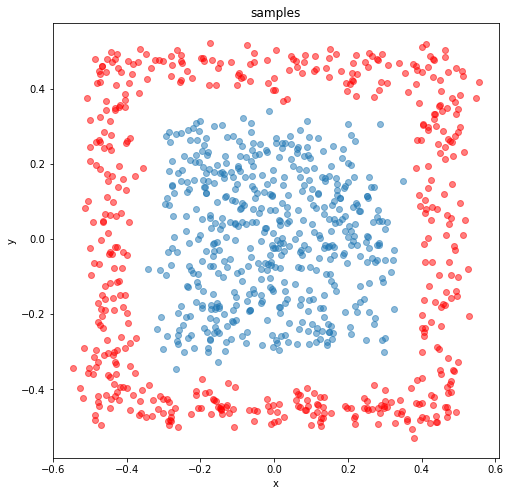

In [4]:
plt.figure(figsize=(8,8))
plt.scatter(Xapp[0:nbapp-1,0],Xapp[0:nbapp-1:,1],alpha=0.5)
plt.scatter(Xapp[nbapp:2*nbapp-1,0],Xapp[nbapp:2*nbapp-1:,1],alpha=0.5,c='r')
plt.xlabel('x')  
plt.ylabel('y')  
plt.title("samples") 
plt.show()

Apprentissage de la règle de décision et définition des paramètres du noyau

In [5]:
#paramètres:
kern='rbf'
gam=25
Cpen=110
deg=5


classifier = svm.SVC(kernel=kern,gamma=gam,C=Cpen)
#classifier = svm.SVC(kernel='poly',degree=deg,C=Cpen)

classifier.fit(Xapp, Lapp)
y_app_pred = classifier.decision_function(Xapp)
lab_app_pred = np.sign(y_app_pred)
y_test_pred = classifier.decision_function(Xtest)
lab_test_pred = np.sign(y_test_pred)

eval_app=lab_app_pred-Lapp
eval_test=lab_test_pred-Ltest

Estimation des performance d'apprentissage et de test

In [5]:
[sum(abs(eval_app))/nbapp/2/2,sum(abs(eval_test))/nbtest/2/2]

[0.0, 0.00117]

Parcours d'une grille 2D pour affichage de la valeur de la fonction SVM

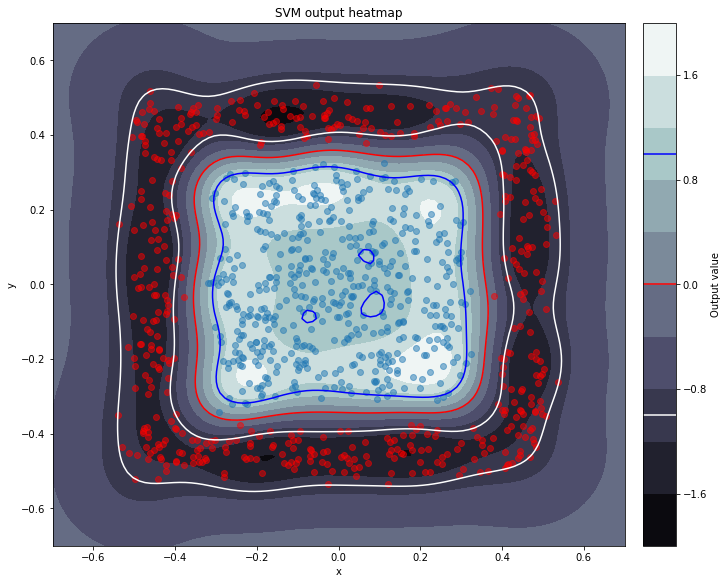

In [12]:
BX=0.7 
origin = 'lower'
nbs=100
delta=(2*BX)/(nbs-1)
x = y = np.arange(-BX, BX+0.0001, delta)
X, Y = np.meshgrid(x, y)
Xr=np.reshape(X,(nbs*nbs,1))
Yr=np.reshape(Y,(nbs*nbs,1))
Xmap=np.concatenate((Xr, Yr), axis=1)
Ymapr = classifier.decision_function(Xmap)
Ymap=np.reshape(Ymapr,(nbs,nbs))



fig1, ax1 = plt.subplots(constrained_layout=True,figsize=(10,8))
#fig1, ax1 = plt.subplots(constrained_layout=True)
CS = ax1.contourf(X, Y, Ymap, 10, cmap=plt.cm.bone, origin=origin)
ax1.set_title('SVM output heatmap')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

CS2 = ax1.contour(CS, levels=(-1,0,1), colors=('w','r','b'), origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Output value')
cbar.add_lines(CS2)

ax1.scatter(Xapp[0:nbapp-1,0],Xapp[0:nbapp-1,1],alpha=0.5)
ax1.scatter(Xapp[nbapp:2*nbapp-1,0],Xapp[nbapp:2*nbapp-1,1],c='r',alpha=0.5)

plt.show()

Determination de la courbe COR

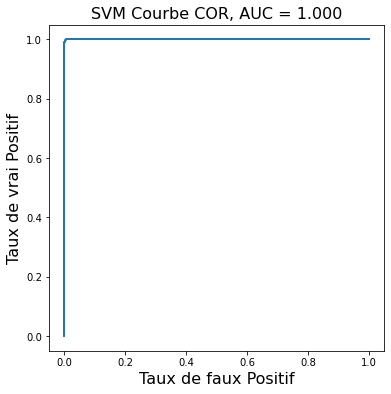

In [7]:
from sklearn import metrics
fpr, tpr, thr = metrics.roc_curve(Ltest,y_test_pred)

# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='Lineaire, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('Taux de faux Positif', fontsize=16)
plt.ylabel('Taux de vrai Positif', fontsize=16)
plt.title('SVM Courbe COR, AUC = %.3f'%auc, fontsize=16)

# afficher l'image
plt.show()

Recherche du meilleur modèle

In [8]:
res_auc=np.zeros((100,1))
k=0
Vgam=[0.1,0.5,1,2,5,10,15,20,50,200]
VCsvc=np.logspace(start=-2,stop=4,num=10)
print(VCsvc)
for gam in Vgam:
    k=k+1
    l=0;
    print('.')
    for Csvc in VCsvc:
        l=l+1
        ind=(k-1)*10+l-1
        classifier = svm.SVC(kernel='rbf',gamma=gam, C=Csvc)

        classifier.fit(Xapp, Lapp)
        y_app_pred = classifier.decision_function(Xapp)
        lab_app_pred = np.sign(y_app_pred)
        y_test_pred = classifier.decision_function(Xtest)
        lab_test_pred = np.sign(y_test_pred)
        fpr, tpr, thr = metrics.roc_curve(Ltest,y_test_pred)
        res_auc[ind] = metrics.auc(fpr, tpr)

pmn=np.argmin(-res_auc)
nk=pmn//10
nl=pmn-10*nk
gam=Vgam[nk]
Csvc=VCsvc[nl]

classifier = svm.SVC(kernel='rbf',gamma=gam, C=Csvc)

classifier.fit(Xapp, Lapp)
y_app_pred = classifier.decision_function(Xapp)
lab_app_pred = np.sign(y_app_pred)
y_test_pred = classifier.decision_function(Xtest)
lab_test_pred = np.sign(y_test_pred)
print(np.max(res_auc))
print([sum(abs(eval_app))/nbapp/2/2,sum(abs(eval_test))/nbtest/2/2])

[1.00000000e-02 4.64158883e-02 2.15443469e-01 1.00000000e+00
 4.64158883e+00 2.15443469e+01 1.00000000e+02 4.64158883e+02
 2.15443469e+03 1.00000000e+04]
.
.
.
.
.
.
.
.
.
.
0.9999988747
[0.0, 0.00117]


Affichage du meilleur modèle

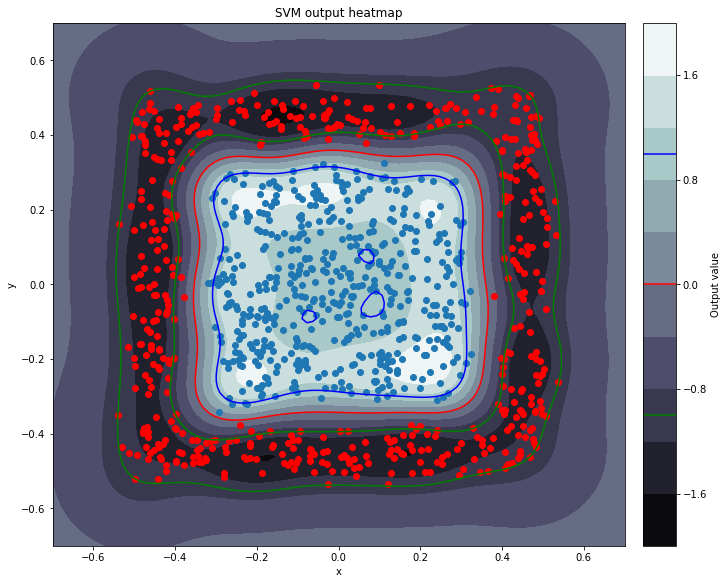

In [9]:
BX=0.7 
origin = 'lower'
nbs=100
delta=(2*BX)/(nbs-1)
x = y = np.arange(-BX, BX+0.0001, delta)
X, Y = np.meshgrid(x, y)
Xr=np.reshape(X,(nbs*nbs,1))
Yr=np.reshape(Y,(nbs*nbs,1))
Xmap=np.concatenate((Xr, Yr), axis=1)
Ymapr = classifier.decision_function(Xmap)
Ymap=np.reshape(Ymapr,(nbs,nbs))



fig1, ax1 = plt.subplots(constrained_layout=True,figsize=(10,8))
CS = ax1.contourf(X, Y, Ymap, 10, cmap=plt.cm.bone, origin=origin)
ax1.set_title('SVM output heatmap')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

CS2 = ax1.contour(CS, levels=(-1,0,1), colors=('g','r','b'), origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Output value')
cbar.add_lines(CS2)

ax1.scatter(Xapp[0:nbapp-1,0],Xapp[0:nbapp-1,1])
ax1.scatter(Xapp[nbapp:2*nbapp-1,0],Xapp[nbapp:2*nbapp-1,1],c='r')

plt.show()